In [25]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from time import time
import csv
import pickle
import os
from tqdm import tqdm
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from sklearn.ensemble import RandomForestClassifier

# Libraries to perform hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from xgboost import XGBClassifier
from xgboost import plot_importance  ## to plot feature importance

# Evaluation metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix

# To save the final model on disk
from sklearn.externals import joblib  ## Reference http://scikit-learn.org/stable/modules/model_persistence.html

Making train n test data from h5 files

In [2]:
df_final_train = read_hdf('data/fea_sample/storage_sample_stage3.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage3.h5', 'test_df',mode='r')

In [3]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,same_comp,shortest_path,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d
0,273084,1505602,1,0,0.000000,0,0,6,15,8,...,1,4,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15
1,695719,1789385,1,0,0.064516,0,0,31,14,19,...,1,2,3.407072e-07,2.635789e-06,0.000747,0.000852,9.371449e-14,9.901274e-16,9.827517e-18,4.362885e-15
2,1179287,868071,1,0,0.000000,0,0,12,4,10,...,1,6,7.588235e-07,1.157516e-06,0.000743,0.000777,2.775366e-16,9.476531e-14,6.701010e-16,2.354745e-15
3,23759,1593616,1,0,0.000000,0,0,36,8,37,...,1,5,6.899680e-07,3.038980e-06,0.000771,0.000871,1.581682e-17,1.922806e-13,1.369456e-15,1.002200e-16
4,674720,1418022,1,0,0.015625,0,0,13,60,5,...,1,2,4.488952e-06,6.102045e-07,0.000952,0.000785,2.148453e-13,9.777021e-16,6.147529e-14,1.028547e-14


In [4]:
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,same_comp,shortest_path,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d
0,848424,784690,1,0,0.000000,0,0,14,6,9,...,1,2,6.557971e-07,1.559547e-06,0.000754,0.000786,3.243237e-16,1.745627e-16,2.969838e-15,9.269213e-14
1,1164002,535503,1,0,0.000000,0,0,4,5,9,...,1,6,2.556697e-06,8.429904e-07,0.000781,0.000747,7.697413e-14,1.702724e-15,2.306692e-13,3.089829e-18
2,174228,246981,1,0,0.272727,0,0,12,14,14,...,1,2,5.595250e-07,6.537908e-07,0.000771,0.000778,8.290337e-15,9.346708e-15,4.395021e-16,4.373422e-16
3,1162782,56929,1,0,0.000000,0,0,0,1,1,...,1,-1,8.815667e-07,1.655650e-07,0.000739,0.000731,0.000000e+00,1.812323e-26,2.524954e-24,0.000000e+00
4,338695,639905,1,0,0.025424,0,0,100,11,110,...,1,2,8.598542e-07,6.357291e-06,0.000770,0.001132,4.168458e-15,6.561039e-13,6.513795e-15,4.816805e-13


In [5]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d'],
      dtype='object')

Target data

In [6]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

Droping unwanted columns and target var.

In [7]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

inefficient

In [ ]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

inefficient

In [ ]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

# Model building

* df_final_train contain all features

In [20]:
df_final_train.head()

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,...,same_comp,shortest_path,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d
0,0,0.000000,0,0,6,15,8,0,0,0.000000,...,1,4,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15
1,0,0.064516,0,0,31,14,19,2,2,2.033938,...,1,2,3.407072e-07,2.635789e-06,0.000747,0.000852,9.371449e-14,9.901274e-16,9.827517e-18,4.362885e-15
2,0,0.000000,0,0,12,4,10,0,0,0.000000,...,1,6,7.588235e-07,1.157516e-06,0.000743,0.000777,2.775366e-16,9.476531e-14,6.701010e-16,2.354745e-15
3,0,0.000000,0,0,36,8,37,0,0,0.000000,...,1,5,6.899680e-07,3.038980e-06,0.000771,0.000871,1.581682e-17,1.922806e-13,1.369456e-15,1.002200e-16
4,0,0.015625,0,0,13,60,5,3,1,0.715338,...,1,2,4.488952e-06,6.102045e-07,0.000952,0.000785,2.148453e-13,9.777021e-16,6.147529e-14,1.028547e-14


* All the target variable of df_final_train

In [21]:
y_train.head()

0    1
1    1
2    1
3    1
4    1
Name: indicator_link, dtype: int64

# Model : RandomForest Classification

In [ ]:
param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

In [ ]:
print(rf_random.best_estimator_)

These are the best parameters

In [ ]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False

test set

In [ ]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

f1 score

In [ ]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [ ]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

roc auc

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

feature importance

In [ ]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
#y_test('source','dest')ytestpred()

# Model: XGBoost Classification

In [8]:
start_time = time()

tuned_params = {'max_depth': [1, 2, 3, 4, 5], 'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [100, 200, 300, 400, 500], 'reg_lambda': [0.001, 0.1, 1.0, 10.0, 100.0]}
model = RandomizedSearchCV(XGBClassifier(), tuned_params, n_iter=15, scoring = 'roc_auc', n_jobs=-1)
model.fit(df_final_train,y_train) # actual data and actual prediction

print("--- %s seconds ---" % (time() - start_time))

--- 498.8528232574463 seconds ---


In [9]:
model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1.0, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

* In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled.

In [27]:
start_time = time()
# tuned_params = {'max_depth': [4], 'learning_rate': [0.05], 'n_estimators': [500], 'reg_lambda': [1.0]}

clf = GridSearchCV(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1.0, scale_pos_weight=1, seed=None,
       silent=True, subsample=1), tuned_params, scoring = 'roc_auc', n_jobs=-1)

clf.fit(df_final_train,y_train) # actual data and actual prediction

print("--- %s seconds ---" % (time() - start_time))

--- 250.4661111831665 seconds ---


test set

In [28]:
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

C:\Users\Rohan Gore\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Rohan Gore\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


f1 score

F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account.

In [29]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.978530960140386
Test f1 score 0.92705173620686


confusion metrics

In [41]:
confusion_matrix(y_test, y_test_pred).T

array([[24710,  3077],
       [  362, 21852]], dtype=int64)

In [30]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


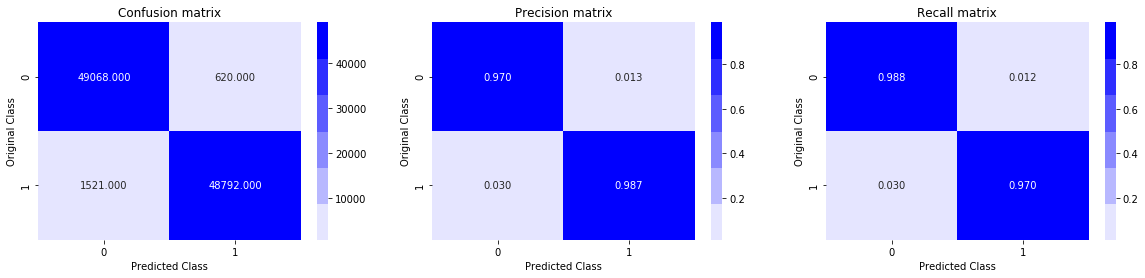

Test confusion_matrix


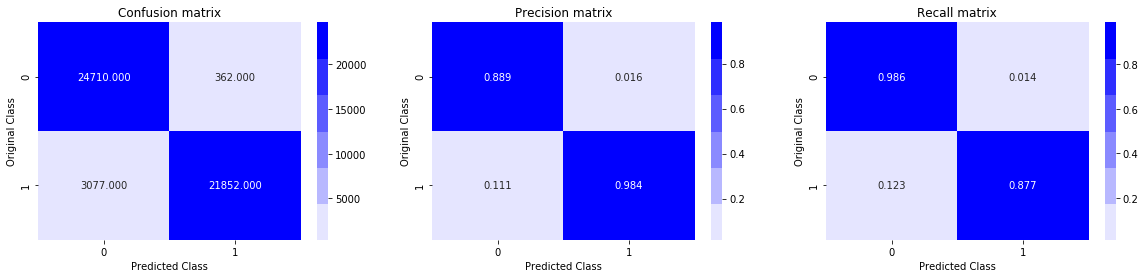

In [31]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

roc auc

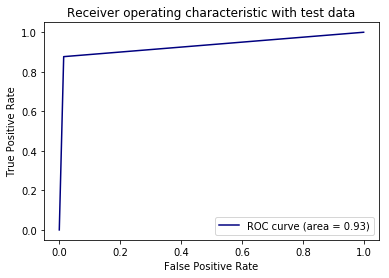

In [32]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

In [36]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

Testing

In [38]:
from sklearn.metrics import accuracy_score
acc=accuracy_score(y_test,y_test_pred,normalize=True)*float(100)
print(acc)

93.12213755724885


Training

In [40]:
acc=accuracy_score(y_train,y_train_pred,normalize=True)*float(100)
print(acc)

97.85902140978591
